<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/SB_test_to_pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЦК ПиМОП занимается прогнозированием финансового результата в разрезе до отдельных статей дохода для всех территориальных подразделений. 
Вам предлагается сформировать прогноз для всех подразделений на примере одной статьи.


В приложенном .xlsx-файле есть два листа: months и days. Смысл полей:
*   report_dt: отчётная дата (конец месяца для месячных данных и день для дневных);
*   territ_subdiv_1: первый уровень дробления по территориям;
*   territ_subdiv_2: второй уровень дробления по территориям. Обратите внимание на нумерацию: в разных подразделениях первого уровня содержится разное число подразделений второго уровня;
*   val: комиссионный доход.

##Задание:
Для представленных на листе months месячных данных сформируйте помесячный прогноз на 2020 год для всех подразделений.
Для ноября 2020 года в начале года был сформирован прогноз 3188.91. Используя дневные данные на листе days, уточните этот прогноз.


## Для представленных на листе months месячных данных сформируйте помесячный прогноз на 2020 год для всех подразделений.

###Импорт библиотек

In [293]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter

import datetime
import calendar
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf

In [294]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Загрузка данных

In [295]:
dfname=pd.ExcelFile('/content/drive/My Drive/2_5393425784910121785.xlsx') #загружаем файл
print(dfname.sheet_names) #какие листы есть в файле

['months', 'days']


In [296]:
months=pd.read_excel('/content/drive/My Drive/2_5393425784910121785.xlsx', sheet_name='months') #загружаем данные с листа months
months.head(10) #что там?

,report_dt,territ_subdiv_1,territ_subdiv_2,val
0,2015-01-31,1,1,1.0
1,2015-01-31,1,2,1.0
2,2015-01-31,1,3,1.0
3,2015-01-31,1,4,1.0
4,2015-01-31,1,5,1.0
5,2015-01-31,1,6,1.0
6,2015-01-31,2,1,1.0
7,2015-01-31,2,2,1.0
8,2015-01-31,2,3,1.0
9,2015-01-31,2,4,1.0


In [297]:
months.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5367 entries, 0 to 5366
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   report_dt        5367 non-null   datetime64[ns]
 1   territ_subdiv_1  5367 non-null   int64         
 2   territ_subdiv_2  5367 non-null   int64         
 3   val              5367 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 167.8 KB


In [298]:
months.describe()

,territ_subdiv_1,territ_subdiv_2,val
count,5367.000000,5367.000000,5367.000000
mean,6.435998,5.382337,2.046112
std,3.020608,3.252553,0.830536
min,1.000000,1.000000,0.009468
25%,5.000000,3.000000,1.404189
50%,7.000000,5.000000,1.989685
75%,9.000000,8.000000,2.540447
max,11.000000,15.000000,10.413210


In [299]:
months.isnull().sum()

report_dt          0
territ_subdiv_1    0
territ_subdiv_2    0
val                0
dtype: int64

Пустых ячеек нет, это хорошо

In [300]:
#сколько всего поразделений первого уровня
SD1_unique = months.territ_subdiv_1.unique() #список уникальных подразделений 1 уровня
SD1_num = len(SD1_unique) #количество подразделений 1 уровня
num = 0 #общий счётчик подразделений

#сколько поразделений второго уровня в подразделениях первого уровня
for SD1 in SD1_unique:
  SD2_unique = months[(months.territ_subdiv_1)==SD1].territ_subdiv_2.unique() #список уникальных подразделений 2 уровня
  SD2_num = len(SD2_unique) #количество подразделений 2 уровня
  print('В подразделении ', SD1, 'всего ', SD2_num, 'подразделений второго уровня:', SD2_unique)
  num += SD2_num
print('')
print('Всего', SD1_num, 'подразделений первого уровня:', SD1_unique)
print('Всего', num, 'подразделений')

В подразделении  1 всего  6 подразделений второго уровня: [1 2 3 4 5 6]
В подразделении  2 всего  9 подразделений второго уровня: [1 2 3 4 5 6 7 8 9]
В подразделении  3 всего  4 подразделений второго уровня: [1 2 3 4]
В подразделении  4 всего  1 подразделений второго уровня: [2]
В подразделении  5 всего  15 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
В подразделении  6 всего  10 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10]
В подразделении  7 всего  8 подразделений второго уровня: [1 2 3 4 5 6 7 8]
В подразделении  8 всего  11 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10 11]
В подразделении  9 всего  8 подразделений второго уровня: [1 2 3 4 5 6 7 8]
В подразделении  10 всего  10 подразделений второго уровня: [ 1  2  3  4  5  6  7  8  9 10]
В подразделении  11 всего  8 подразделений второго уровня: [1 2 3 4 5 6 7 8]

Всего 11 подразделений первого уровня: [ 1  2  3  4  5  6  7  8  9 10 11]
Всего 90 подразделений


In [301]:
#превращаем колонку с датой в DateTimeIindex
months.index = pd.to_datetime(months.report_dt) 
months.drop('report_dt', axis=1, inplace=True)
months.head()

,territ_subdiv_1,territ_subdiv_2,val
report_dt,,,
2015-01-31,1,1,1.0
2015-01-31,1,2,1.0
2015-01-31,1,3,1.0
2015-01-31,1,4,1.0
2015-01-31,1,5,1.0


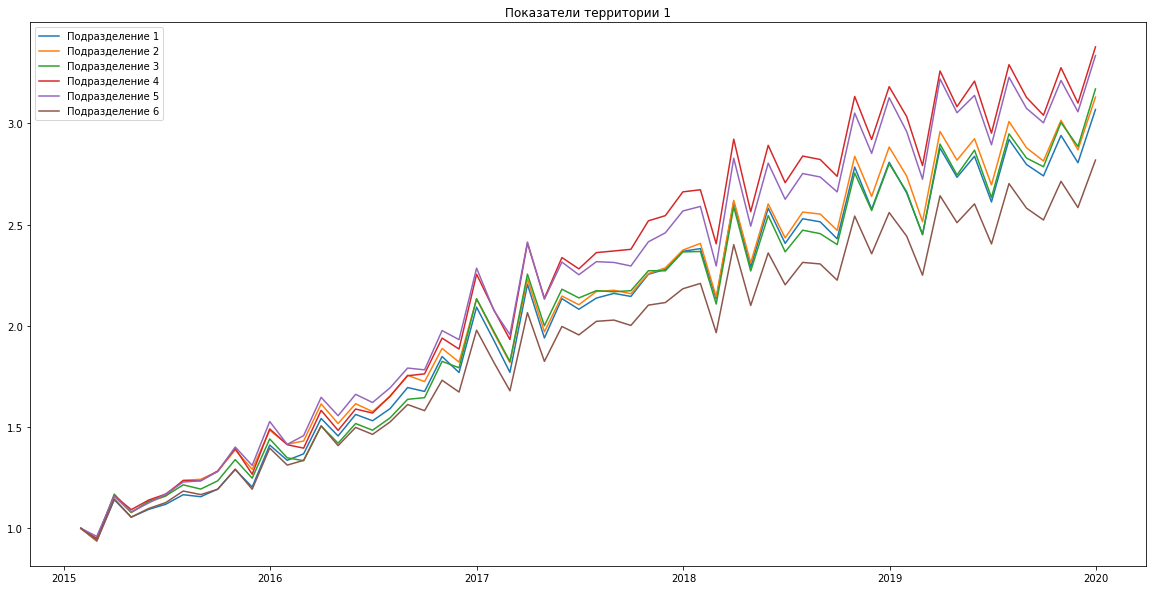

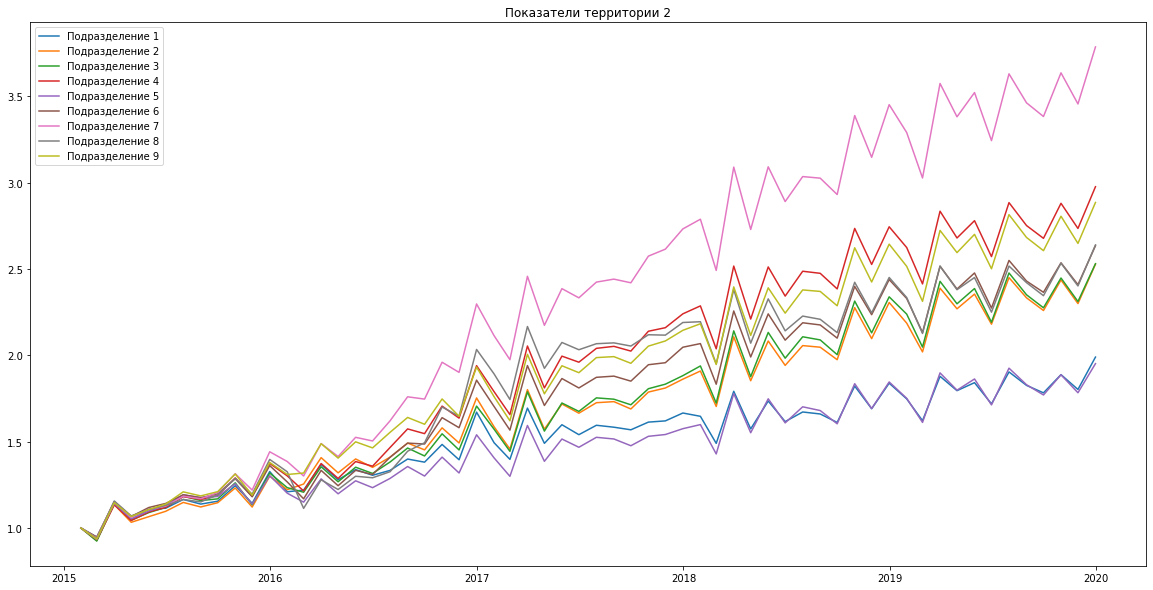

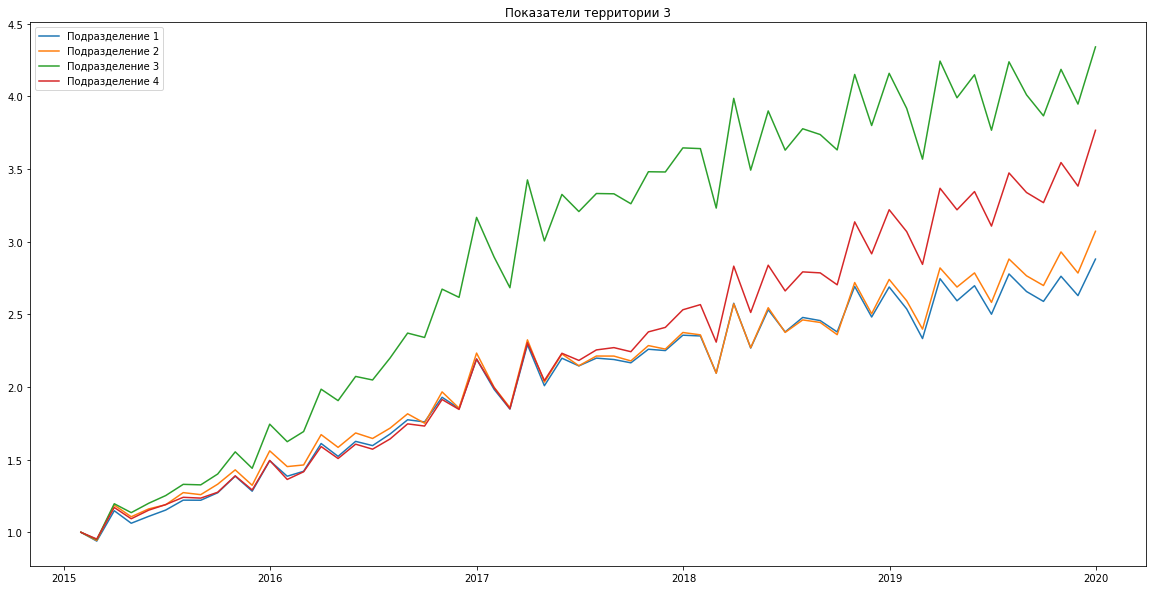

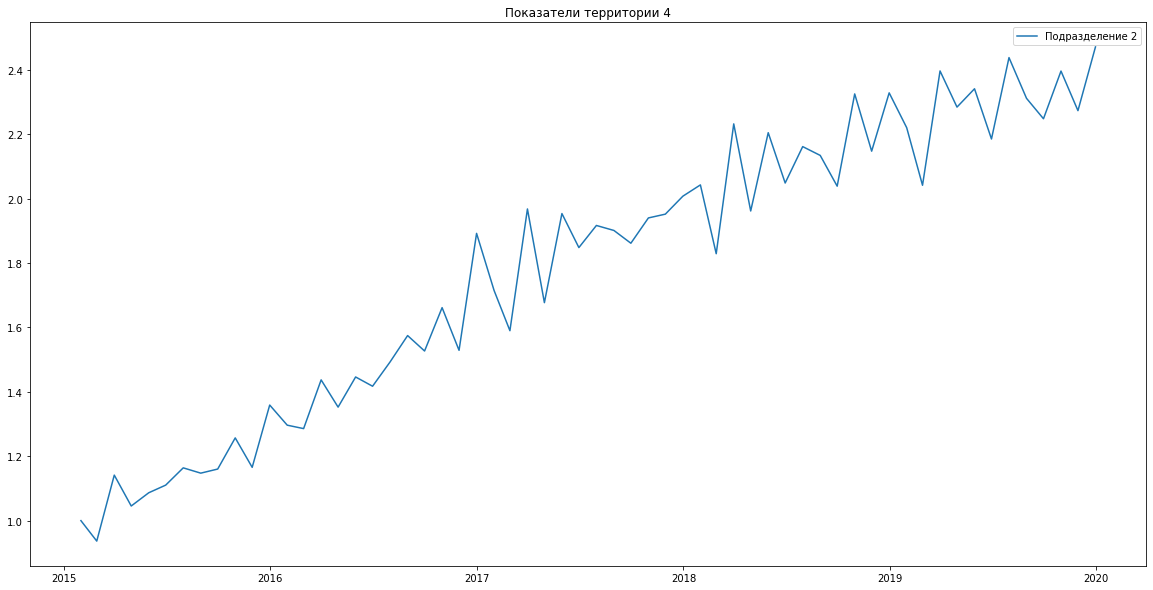

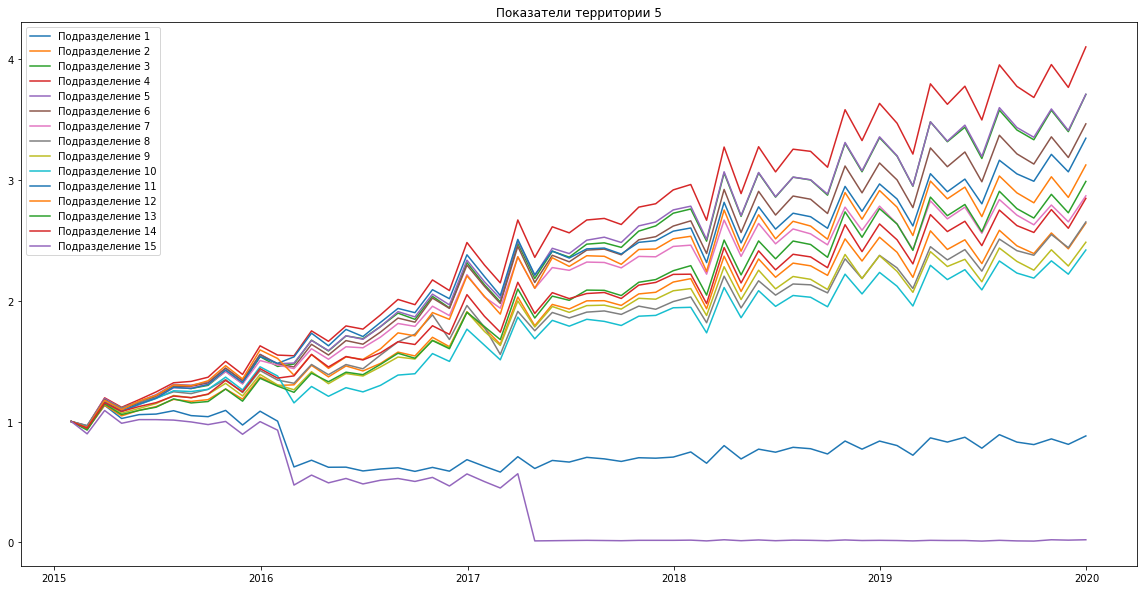

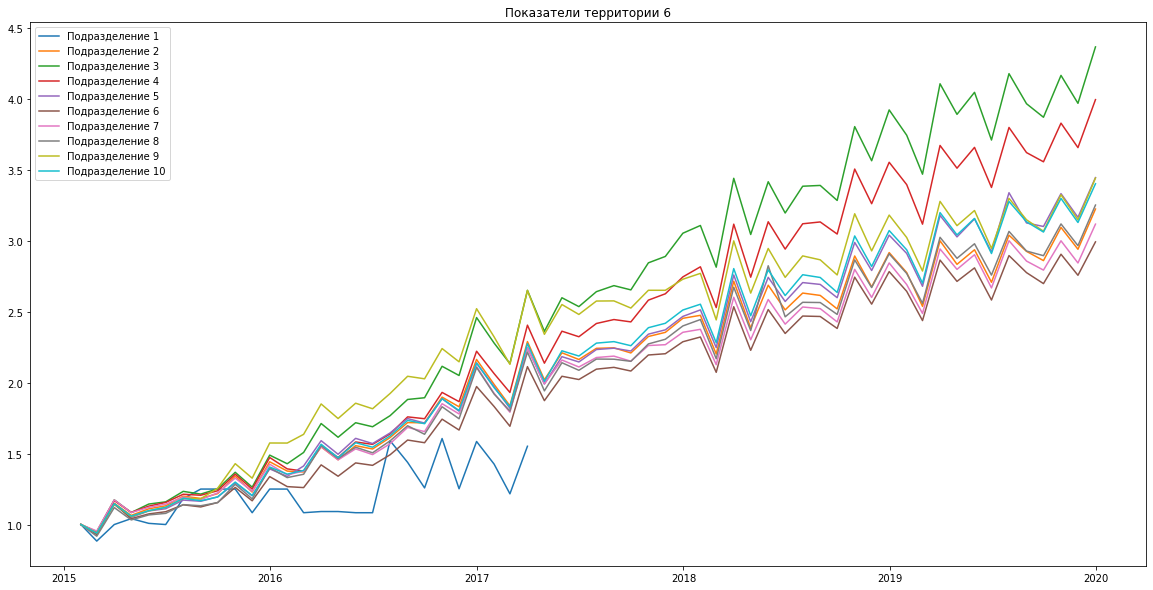

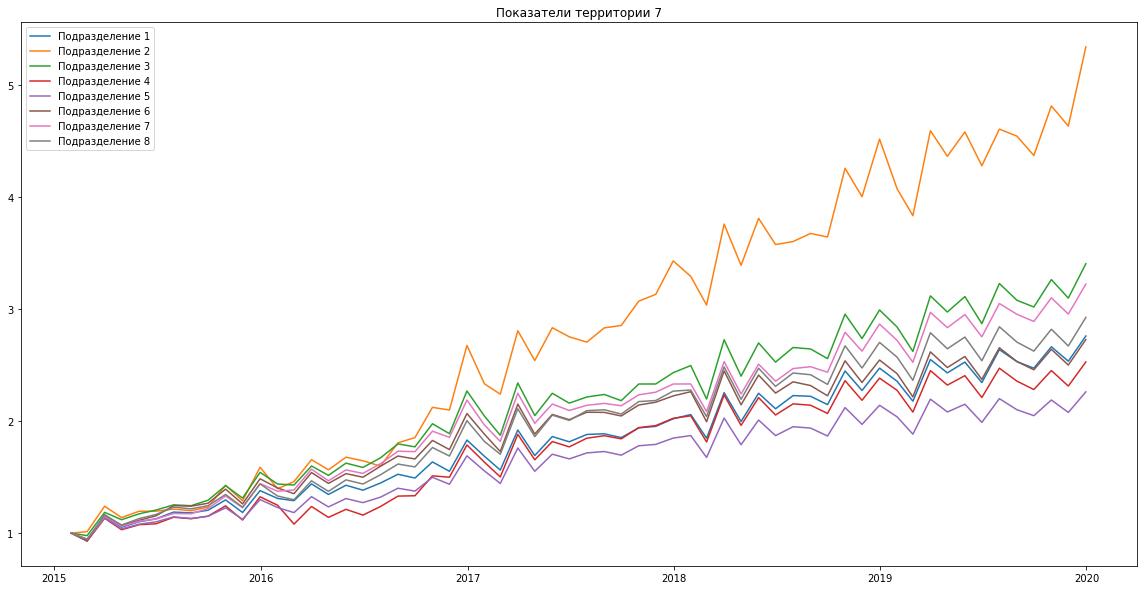

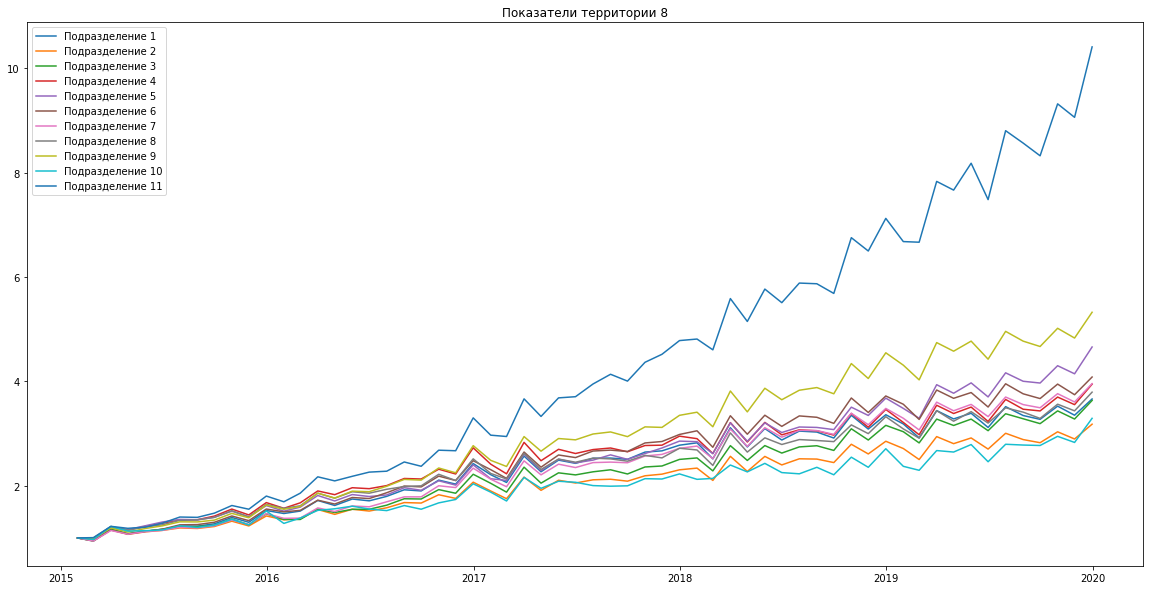

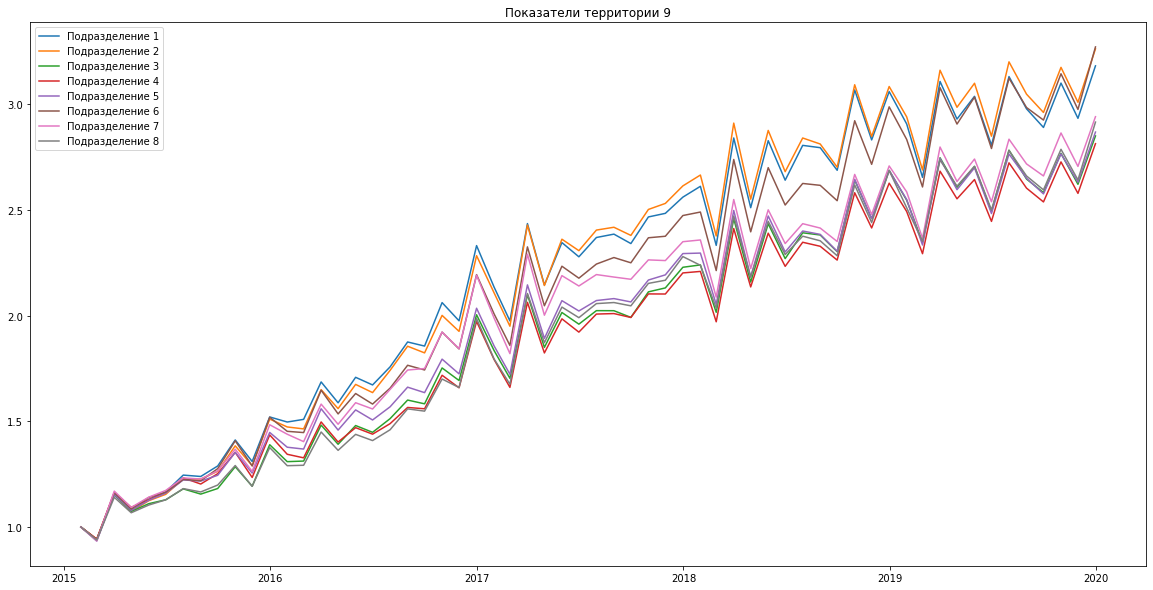

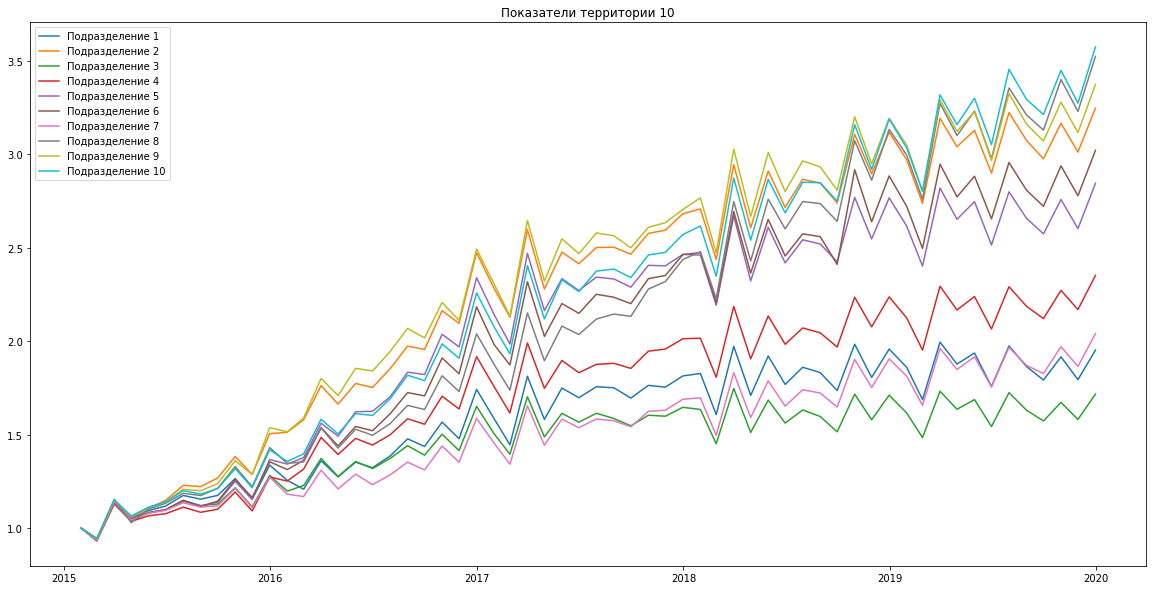

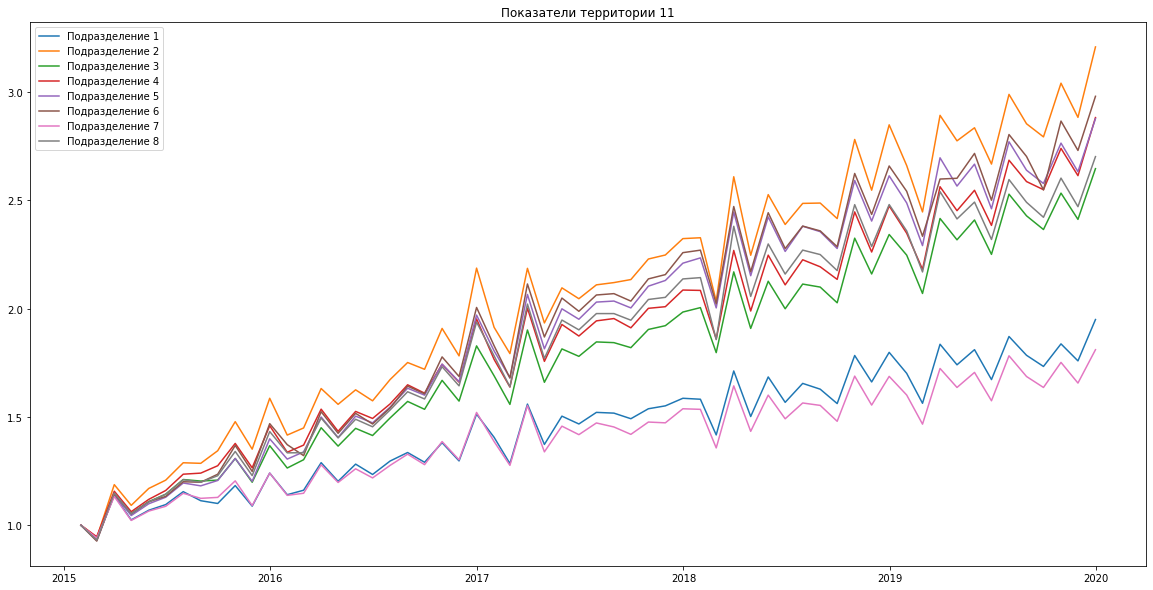

In [302]:
for SD1 in SD1_unique:
  DF_SD1 = pd.DataFrame(months[((months.territ_subdiv_1)==SD1)]) #датафрейм, содержащий все подразделения данной территории
  SD2_unique = DF_SD1.territ_subdiv_2.unique() #список уникальных подразделений 2 уровня 
  
  # построим графики
  plt.figure(figsize=(20,10))
  plt.title(f'Показатели территории {SD1}')
  
  # Создадим отдельный файл с данными для каждого подразделения
  for SD2 in SD2_unique: # для каждого подразделения в списке для данной территории
    export_file_path = str(SD1) + '-' + str(SD2) # определяем название файла
    
    DF = pd.DataFrame(DF_SD1[((DF_SD1.territ_subdiv_2)==SD2)]) #датафрейм с данными подразделения
    DF.to_csv(export_file_path, columns=['val']) #записываем в файл
    
    data_to_read = pd.read_csv(export_file_path)
    data_to_read.index = pd.to_datetime(data_to_read.report_dt) 
    data_to_read.drop('report_dt', axis=1, inplace=True)
    
    plt.plot(data_to_read, label=f'Подразделение {SD2}') # строим график для данного подразделения 
    plt.legend()
  
  # выведем данные на графике
  plt.show()

In [11]:
data_6_1 = pd.read_csv('6-1')
data_6_1.shape

(27, 2)

По графикам видно, что для Подразделения 1 Территории 6 отсутствет часть данных

###Тренд и сезонность
Растущий тренд, в общем, очевиден, выраженной сезонности не заметно

In [12]:
dates = months.index
months['Year']= dates.year
months['Month']= dates.month
months['Month'] = months['Month'].apply(lambda x: calendar.month_abbr[x])
data = months[['Month','Year','territ_subdiv_1',	'val']]
monthly_data = pd.pivot_table(data, values = "val", columns = ["Year",'territ_subdiv_1'], index = "Month")
monthly_data = monthly_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

monthly_data

Year                 2015                      ...      2019                    
territ_subdiv_1        1         2         3   ...        9         10        11
Month                                          ...                              
Jan              1.000000  1.000000  1.000000  ...  2.669866  2.479516  2.242950
Feb              0.945130  0.936700  0.946645  ...  2.454885  2.277422  2.064955
Mar              1.155666  1.144940  1.175700  ...  2.881195  2.681790  2.407839
Apr              1.073562  1.054507  1.099392  ...  2.727412  2.536902  2.312553
May              1.119951  1.099513  1.155787  ...  2.832687  2.629098  2.397410
Jun              1.150718  1.124235  1.196524  ...  2.612744  2.417726  2.228448
Jul              1.211168  1.180105  1.266270  ...  2.916905  2.706382  2.502901
Aug              1.204878  1.160256  1.260339  ...  2.785455  2.575213  2.396199
Sep              1.244378  1.182916  1.319990  ...  2.715406  2.499165  2.327662
Oct              1.350977  1.275926  1.439538  ...  2.915519  2.681554  2.516534
Nov              1.252457  1.167294  1.334564  ...  2.761520  2.541560  2.394331
Dec              1.458887  1.355708  1.573098  ...  3.012197  2.764222  2.631570

[12 rows x 55 columns]

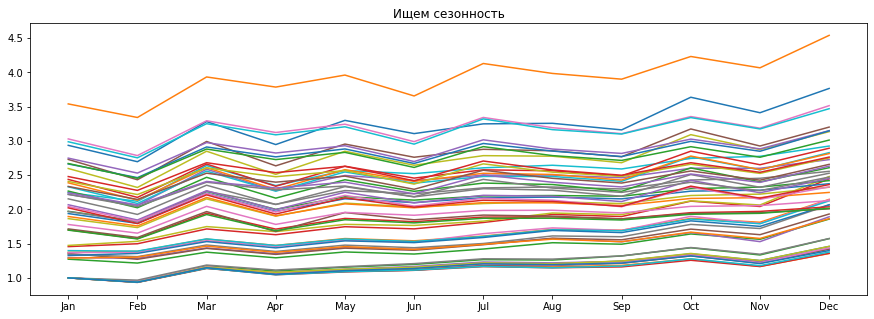

In [13]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data)
plt.title('Ищем сезонность')
plt.show()

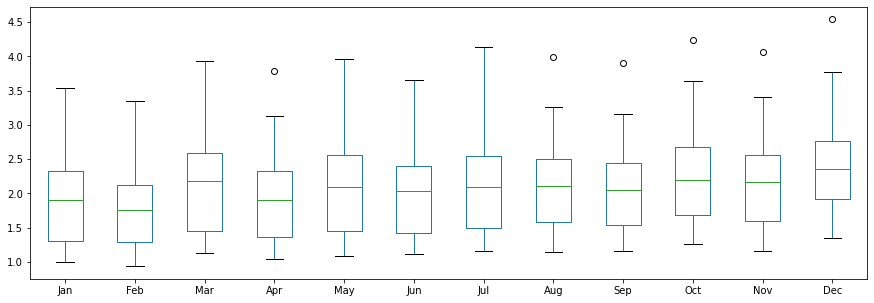

In [14]:
monthly_data.T.boxplot(grid=False, figsize=(15,5))
plt.show()

In [15]:
yearly_data = pd.pivot_table(data, values = "val", columns = ["Month",'territ_subdiv_1'], index = "Year")
yearly_data = yearly_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_data

Month                 Jan                      ...       Dec                    
territ_subdiv_1        1         2         3   ...        9         10        11
Year                                           ...                              
2015             1.000000  1.000000  1.000000  ...  1.460233  1.377176  1.399312
2016             1.373268  1.272906  1.456327  ...  2.124443  2.067864  1.864111
2017             1.971380  1.701755  2.217913  ...  2.374659  2.247919  2.015041
2018             2.437779  2.067909  2.729449  ...  2.815116  2.608832  2.362461
2019             2.748724  2.335041  3.029285  ...  3.012197  2.764222  2.631570

[5 rows x 132 columns]

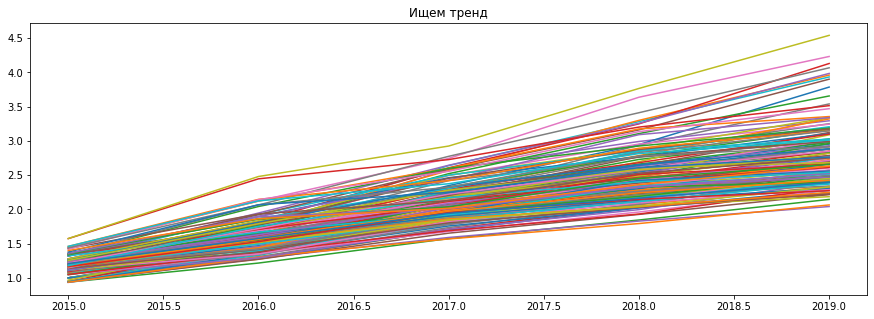

In [16]:
plt.figure(figsize=(15,5))
plt.plot(yearly_data)
plt.title('Ищем тренд')
plt.show()

###Моделирование

In [303]:
#выберем данные для моделирования
SD1 = 1 #Территория
SD2 = 6 #Подразделение

file_path = str(SD1) + '-' + str(SD2) #название файла
data_to_read = pd.read_csv(file_path) #читаем файл
data_to_read.index = pd.to_datetime(data_to_read.report_dt) 
data_to_read.drop('report_dt', axis=1, inplace=True)
      
train = (data_to_read[data_to_read.index < '2018-01-01']) #тренировочные данные
test = (data_to_read[data_to_read.index >= '2018-01-01']) #тестовые данные

####Auto Regresive


In [28]:
# Определим параметры для модели
model = AR(train)
model_fit = model.fit()

# Количество лагов, их значения
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)  

Lag: 9
Coefficients: const     0.170369
L1.val   -0.140179
L2.val    0.184326
L3.val    0.615634
L4.val    0.109376
L5.val    0.168308
L6.val   -0.331537
L7.val    0.101887
L8.val   -0.008627
L9.val    0.295482
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [29]:
# сделаем прогноз на тестовых данных
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

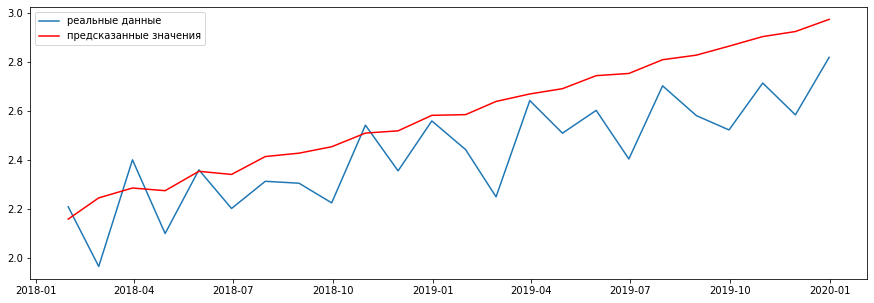

In [30]:
# выведем результаты на графике
plt.figure(figsize=(15,5))
plt.plot(test, label='реальные данные')
plt.plot(predictions, color='red', label='предсказанные значения')
plt.legend()
plt.show()

In [31]:
# Посчитаем ошибку для полученной модели

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['val'], predictions))
rmse = round(rmse, 3)
      
# Mean Absolute Percentage Error
abs_error = np.abs(test['val']-predictions)
actual = test['val']
mape = np.round(np.mean(abs_error/actual),3)

#Запишем результаты в общую таблицу
resultsDf = pd.DataFrame()
tempResultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
    
print(resultsDf)

            Method  RMSE  MAPE
0  Auto Regressive   0.2  0.07


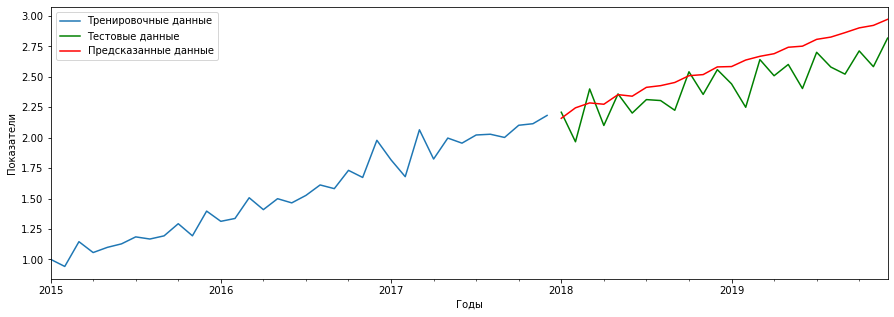

In [32]:
axis = train['val'].plot(label='Тренировочные данные', figsize=(15, 5))
test['val'].plot(ax=axis, label='Тестовые данные', color='g')
predictions.plot(ax=axis, label='Предсказанные данные', color='r')
axis.set_xlabel('Годы')
axis.set_ylabel('Показатели')
plt.legend(loc='best')
plt.show()
plt.close()

####Auto Regressive Moving Average(ARMA)

In [33]:
p = range(0,8)
q = range(0,1)

pdq = list(itertools.product(p,q))

best_aic = np.inf
best_pq = None
temp_model = None

for param in pdq:
  temp_model = ARMA(train, order=param)
  results = temp_model.fit()
  if results.aic < best_aic:
    best_aic = results.aic
    best_pdq = (param)
print("Best ARMA {} model - AIC:{}".format(best_pdq, best_aic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

Best ARMA (2, 0) model - AIC:-47.396033001926426


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
model = ARMA(train,order=(2,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [35]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

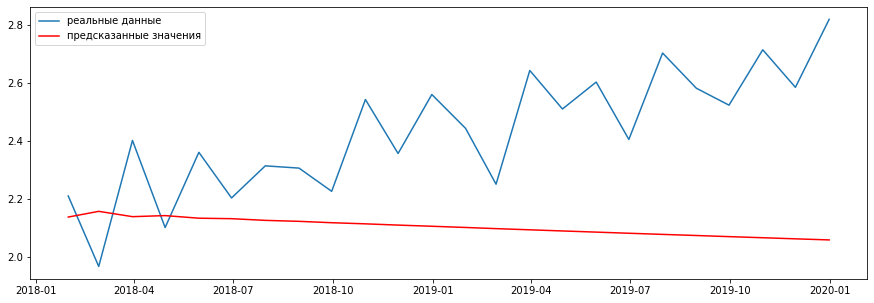

In [36]:
# выведем результаты на графике
plt.figure(figsize=(15,5))
plt.plot(test, label='реальные данные')
plt.plot(predictions, color='red', label='предсказанные значения')
plt.legend()
plt.show()

In [37]:
# Посчитаем ошибку для полученной модели

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['val'], predictions))
rmse = round(rmse, 3)
      
# Mean Absolute Percentage Error
abs_error = np.abs(test['val']-predictions)
actual = test['val']
mape = np.round(np.mean(abs_error/actual),3)

#Запишем результаты в общую таблицу
tempResultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
    
print(resultsDf)

                           Method   RMSE   MAPE
0                 Auto Regressive  0.200  0.070
0  Auto Regressive Moving Average  0.399  0.137


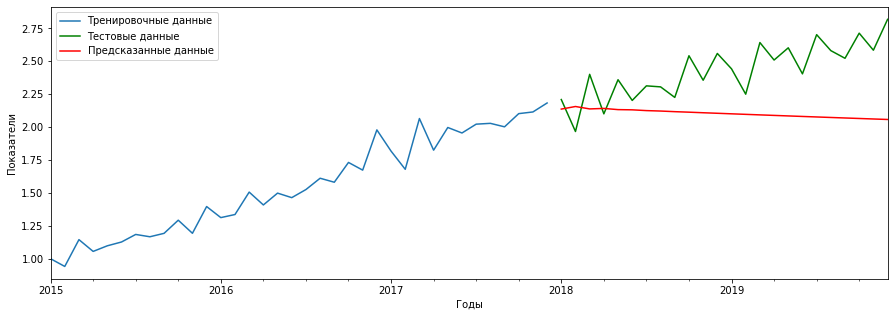

In [38]:
axis = train['val'].plot(label='Тренировочные данные', figsize=(15, 5))
test['val'].plot(ax=axis, label='Тестовые данные', color='g')
predictions.plot(ax=axis, label='Предсказанные данные', color='r')
axis.set_xlabel('Годы')
axis.set_ylabel('Показатели')
plt.legend(loc='best')
plt.show()
plt.close()

####Auto Regressive Integrated Moving Average(ARIMA)

In [39]:
p = range(0,8)
d = range(0,2)
q = range(0,1)

pdq = list(itertools.product(p,d,q))

best_aic = np.inf
best_pdq = None
temp_model = None

for param in pdq:
  temp_model = ARIMA(train, order=param)
  results = temp_model.fit()
  if results.aic < best_aic:
    best_aic = results.aic
    best_pdq = (param)
print("Best ARIMA {} model - AIC:{}".format(best_pdq, best_aic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

Best ARIMA (2, 1, 0) model - AIC:-75.39617999548028


In [40]:
model = ARIMA(train,order=(2,1,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [41]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

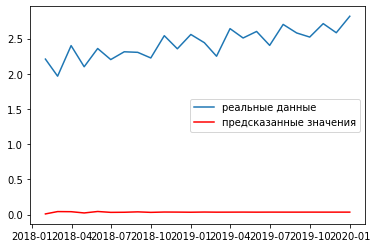

In [42]:
# выведем результаты на графике
plt.figure(figsize=(15,5))
plt.plot(test, label='реальные данные')
plt.plot(predictions, color='red', label='предсказанные значения')
plt.legend()
plt.show()

In [43]:
# Посчитаем ошибку для полученной модели

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['val'], predictions))
rmse = round(rmse, 3)
      
# Mean Absolute Percentage Error
abs_error = np.abs(test['val']-predictions)
actual = test['val']
mape = np.round(np.mean(abs_error/actual),3)

#Запишем результаты в общую таблицу
tempResultsDf = pd.DataFrame({'Method':['Auto Regressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
    
print(resultsDf)

                                      Method   RMSE   MAPE
0                            Auto Regressive  0.200  0.070
0             Auto Regressive Moving Average  0.399  0.137
0  Auto Regressive Integrated Moving Average  2.405  0.986


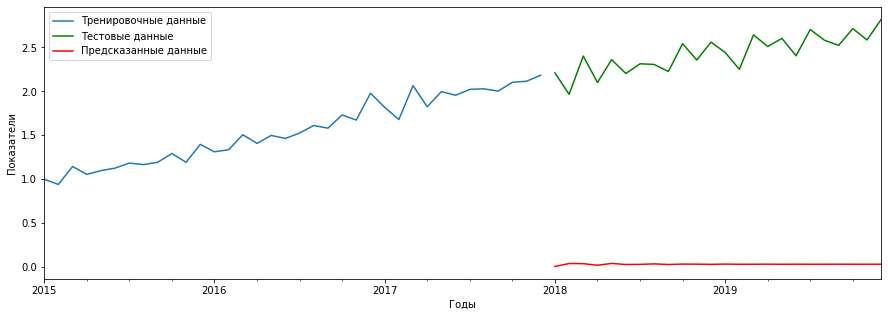

In [44]:
axis = train['val'].plot(label='Тренировочные данные', figsize=(15, 5))
test['val'].plot(ax=axis, label='Тестовые данные', color='g')
predictions.plot(ax=axis, label='Предсказанные данные', color='r')
axis.set_xlabel('Годы')
axis.set_ylabel('Показатели')
plt.legend(loc='best')
plt.show()
plt.close()

####Seasonal Autoregressive Integrated Moving-Average (SARIMA)


In [45]:
p = range(0,8)
d = range(0,2)
q = range(0,1)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(train,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit(disp=1)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

Best ARIMA (0, 1, 0) x (7, 0, 0, 4) model - AIC:-130.57456587414592


In [46]:
model = SARIMAX(train,order=(0,1,0),seasonal_order=(7,0,0,4),enforce_invertibility=False,
                             enforce_stationarity=False)
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

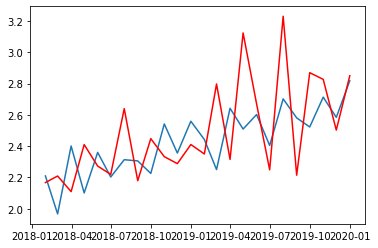

In [48]:
# выведем результаты на графике
plt.figure(figsize=(15,5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [49]:
# Посчитаем ошибку для полученной модели

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['val'], predictions))
rmse = round(rmse, 3)
      
# Mean Absolute Percentage Error
abs_error = np.abs(test['val']-predictions)
actual = test['val']
mape = np.round(np.mean(abs_error/actual),3)

#Запишем результаты в общую таблицу
tempResultsDf = pd.DataFrame({'Method':['Seasonal Autoregressive Integrated Moving-Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
    
print(resultsDf)

                                              Method   RMSE   MAPE
0                                    Auto Regressive  0.200  0.070
0                     Auto Regressive Moving Average  0.399  0.137
0          Auto Regressive Integrated Moving Average  2.405  0.986
0  Seasonal Autoregressive Integrated Moving-Average  0.279  0.093


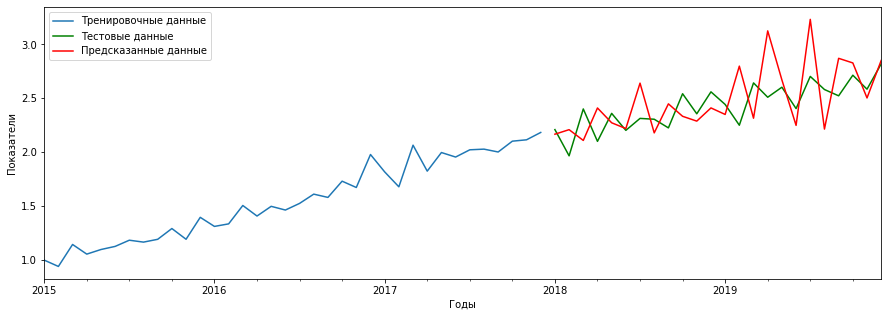

In [50]:
axis = train['val'].plot(label='Тренировочные данные', figsize=(15, 5))
test['val'].plot(ax=axis, label='Тестовые данные', color='g')
predictions.plot(ax=axis, label='Предсказанные данные', color='r')
axis.set_xlabel('Годы')
axis.set_ylabel('Показатели')
plt.legend(loc='best')
plt.show()
plt.close()

###Прогноз
Наименьшую ошибку показала модель авторегрессии.

In [51]:
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,0.200,0.070
0,Auto Regressive Moving Average,0.399,0.137
0,Auto Regressive Integrated Moving Average,2.405,0.986
0,Seasonal Autoregressive Integrated Moving-Average,0.279,0.093


In [372]:
plan_2020_ = pd.DataFrame()
for SD1 in SD1_unique: #для каждой территории
  DF_SD1 = pd.DataFrame(months[((months.territ_subdiv_1)==SD1)]) #датафрейм, содержащий все подразделения данной территории
  SD2_unique = DF_SD1.territ_subdiv_2.unique() #список уникальных подразделений 2 уровня 
  plan_2020 = pd.DataFrame()
  for SD2 in SD2_unique: # для каждого подразделения в списке для данной территории

    file_path = str(SD1) + '-' + str(SD2) #название файла c данными
    data_to_read = pd.read_csv(file_path) #читаем файл
    data_to_read.index = pd.to_datetime(data_to_read.report_dt) 
    data_to_read.drop('report_dt', axis=1, inplace=True)

    # формируем выборки для каждого набора данных  
    train = (data_to_read[data_to_read.index < '2019-01-01']) #тренировочные данные
    test = (data_to_read[data_to_read.index >= '2019-01-01']) #тестовые данные

    model = AR(train)
    model_fit = model.fit()

    # сделаем прогноз 
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1+12, dynamic=False)
    # predictions.index = pd.to_datetime(predictions)
    plan_data = pd.DataFrame({'val':predictions.values[12:]})
    plan_data['report_dt'] = ['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31']
    plan_data.index = pd.to_datetime(plan_data.report_dt) 
    plan_data.drop('report_dt', axis=1, inplace=True)
    plan_data['territ_subdiv_1'] = SD1
    plan_data['territ_subdiv_2'] = SD2
    plan_2020 = pd.concat([plan_data, plan_data])


  plan_2020_ = pd.concat([plan_2020_, plan_2020])
    

plan_2020_=plan_2020_[['territ_subdiv_1', 'territ_subdiv_2', 'val']]
plan_2020_.to_csv('plan_2020') #записываем в файл


In [373]:
read_plan_2020 = pd.read_csv('plan_2020') #читаем файл
read_plan_2020

,report_dt,territ_subdiv_1,territ_subdiv_2,val
0,2020-01-31,1,6,2.749937
1,2020-02-29,1,6,2.827555
2,2020-03-31,1,6,2.838870
3,2020-04-30,1,6,2.834590
4,2020-05-31,1,6,2.913127
...,...,...,...,...
259,2020-08-31,11,8,2.855394
260,2020-09-30,11,8,2.887017
261,2020-10-31,11,8,2.923313
262,2020-11-30,11,8,2.913514


##Для ноября 2020 года в начале года был сформирован прогноз 3188.91. Используя дневные данные на листе days, уточните этот прогноз.

In [194]:
days=pd.read_excel('/content/drive/My Drive/2_5393425784910121785.xlsx',sheet_name='days')
days

,report_dt,territ_subdiv_1,territ_subdiv_2,val
0,2019-05-31,1,1,1.000000
1,2019-05-31,1,2,1.000000
2,2019-05-31,1,3,1.000000
3,2019-05-31,1,4,1.000000
4,2019-05-31,1,5,1.000000
...,...,...,...,...
40968,2020-11-21,11,4,1.473936
40969,2020-11-21,11,5,1.224346
40970,2020-11-21,11,6,1.154639
40971,2020-11-21,11,7,1.288267


In [195]:
days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40973 entries, 0 to 40972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   report_dt        40973 non-null  datetime64[ns]
 1   territ_subdiv_1  40973 non-null  int64         
 2   territ_subdiv_2  40973 non-null  int64         
 3   val              40973 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.3 MB


In [196]:
days.describe()

,territ_subdiv_1,territ_subdiv_2,val
count,40973.000000,40973.000000,40973.000000
mean,6.449540,5.328851,1.258391
std,3.037036,3.143999,0.417794
min,1.000000,1.000000,0.134688
25%,5.000000,3.000000,1.016003
50%,7.000000,5.000000,1.133837
75%,9.000000,8.000000,1.320846
max,11.000000,15.000000,4.160394


In [206]:
days.isna().sum()

territ_subdiv_1    0
territ_subdiv_2    0
val                0
Year               0
Month              0
Day                0
dtype: int64

In [198]:
#превращаем колонку с датой в DateTimeIindex
days.index = pd.to_datetime(days.report_dt) 
days.drop('report_dt', axis=1, inplace=True)
days.head()

,territ_subdiv_1,territ_subdiv_2,val
report_dt,,,
2019-05-31,1,1,1.0
2019-05-31,1,2,1.0
2019-05-31,1,3,1.0
2019-05-31,1,4,1.0
2019-05-31,1,5,1.0


In [ ]:
for SD1 in SD1_unique:
  DF_SD1 = pd.DataFrame(days[((days.territ_subdiv_1)==SD1)]) #датафрейм, содержащий все подразделения данной территории
  SD2_unique = DF_SD1.territ_subdiv_2.unique() #список уникальных подразделений 2 уровня 
  
  # построим графики
  plt.figure(figsize=(20,10))
  plt.title(f'Показатели территории {SD1}')
  
  # Создадим отдельный файл с данными для каждого подразделения
  for SD2 in SD2_unique: # для каждого подразделения в списке для данной территории
    export_file_path = 'Daily' + str(SD1) + '-' + str(SD2) # определяем название файла
    
    DF = pd.DataFrame(DF_SD1[((DF_SD1.territ_subdiv_2)==SD2)]) #датафрейм с данными подразделения
    DF.to_csv(export_file_path, columns=['val']) #записываем в файл
    
    data_to_read = pd.read_csv(export_file_path)
    data_to_read.index = pd.to_datetime(data_to_read.report_dt) 
    data_to_read.drop('report_dt', axis=1, inplace=True)
    
    plt.plot(data_to_read, label=f'Подразделение {SD2}') # строим график для данного подразделения 
    plt.legend()
  
  # выведем данные на графике
  plt.show()

In [265]:
dates = days.index
days['Year']= dates.year
days['Month']= dates.month
days['Month'] = days['Month'].apply(lambda x: calendar.month_abbr[x])
days['Day']= dates.day

daily_data = days.pivot_table('val', dates, ['territ_subdiv_1', 'territ_subdiv_2'] )

daily_data

territ_subdiv_1        1                       ...        11                    
territ_subdiv_2         1         2         3  ...         6         7         8
report_dt                                      ...                              
2019-05-31       1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000
2019-06-01       0.647234  0.672398  0.659519  ...  0.681274  0.680265  0.742855
2019-06-03       1.568463  1.588431  1.649000  ...  1.573696  1.842575  1.707561
2019-06-04       0.816246  0.857406  0.848363  ...  0.791749  0.932600  0.932414
2019-06-05       0.823131  0.831198  0.932138  ...  0.763148  0.903117  0.898103
...                   ...       ...       ...  ...       ...       ...       ...
2020-11-17       1.597701  1.337752  1.315637  ...  1.555240  1.332677  1.342548
2020-11-18       1.210856  1.159224  1.087825  ...  1.174591  1.092864  1.162678
2020-11-19       1.094876  1.120614  1.044319  ...  1.125925  1.170783  1.204255
2020-11-20       1.508113  1.044103  1.409717  ...  1.697773  1.139698  1.130156
2020-11-21       1.249404  1.265885  1.201827  ...  1.154639  1.288267  1.305227

[464 rows x 89 columns]

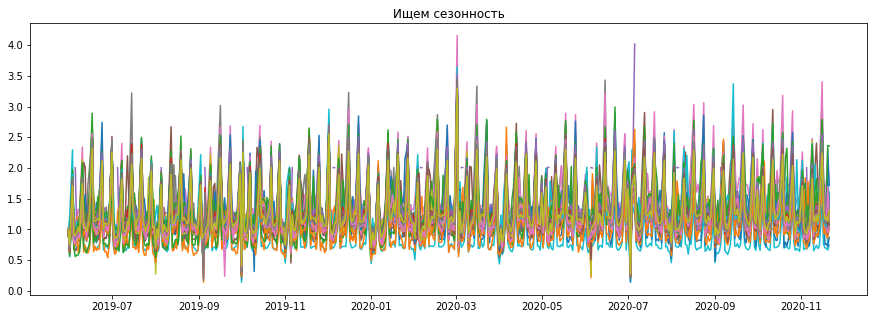

In [266]:
plt.figure(figsize=(15,5))
plt.plot(daily_data)
plt.title('Ищем сезонность')
plt.show()

In [286]:
daily_data_SD1 = days.pivot_table('val', 'Day', ['territ_subdiv_1'])

daily_data_SD1

territ_subdiv_1,1,2,3,4,5,6,7,8,9,10,11
Day,,,,,,,,,,,
1,1.066778,1.063327,1.101279,0.672447,1.067361,1.053585,1.095069,1.083287,1.041365,1.035762,1.118259
2,1.469692,1.450549,1.485999,0.976742,1.489863,1.454671,1.506227,1.523140,1.461792,1.430867,1.533199
3,1.018583,1.010902,1.022985,0.716564,1.072186,1.008676,1.045376,1.105102,1.043222,0.995521,1.043236
4,1.098370,1.078491,1.100665,0.801953,1.155046,1.073239,1.132944,1.193450,1.121449,1.070282,1.125342
5,1.043948,1.005831,1.019706,0.770042,1.153322,1.009490,1.027103,1.143950,1.066161,0.998503,1.093334
6,1.180641,1.126951,1.131606,0.857866,1.274969,1.118624,1.161647,1.304252,1.200087,1.105751,1.205987
7,1.203111,1.168661,1.139022,0.838999,1.210196,1.118115,1.147596,1.214839,1.181884,1.093708,1.182702
8,1.105421,1.055738,1.060941,0.745031,1.143831,1.037657,1.074895,1.125753,1.090455,1.025546,1.102503
9,1.319253,1.246194,1.242684,0.866613,1.338596,1.229562,1.267972,1.323465,1.282941,1.204937,1.305405


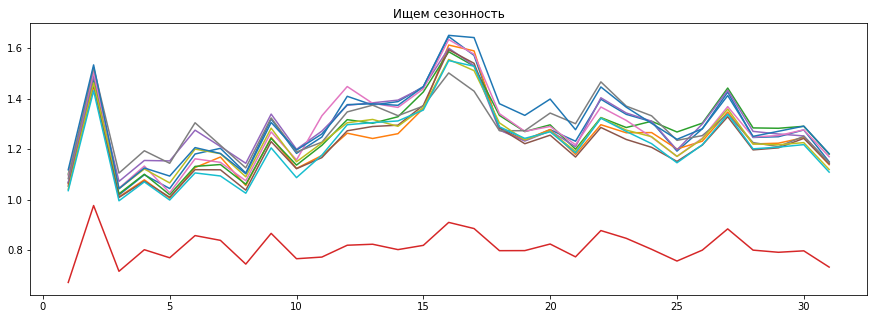

In [288]:
plt.figure(figsize=(15,5))
plt.plot(daily_data_SD1)
plt.title('Ищем сезонность')
plt.show()

In [260]:
monthly_data = days.pivot_table('val', 'Month', ['territ_subdiv_1', 'territ_subdiv_2'] )
monthly_data = monthly_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_data

territ_subdiv_1        1                       ...        11                    
territ_subdiv_2         1         2         3  ...         6         7         8
Month                                          ...                              
Jan              1.226742  1.223806  1.216837  ...  1.172317  1.243559  1.231345
Feb              1.252298  1.246818  1.240549  ...  1.197771  1.266681  1.255463
Mar              1.362326  1.350963  1.354015  ...  1.298135  1.378260  1.359084
Apr              1.245006  1.242997  1.231962  ...  1.190734  1.259988  1.239767
May              1.284475  1.279452  1.280722  ...  1.234880  1.289673  1.279775
Jun              1.244383  1.247350  1.226295  ...  1.190297  1.268262  1.252730
Jul              1.261707  1.264556  1.245500  ...  1.213122  1.293766  1.270043
Aug              1.241643  1.243413  1.227290  ...  1.196115  1.261376  1.248942
Sep              1.264382  1.264465  1.254317  ...  1.198792  1.275338  1.265306
Oct              1.272404  1.270150  1.267970  ...  1.235730  1.283592  1.273426
Nov              1.260288  1.242262  1.261922  ...  1.226522  1.254968  1.243908
Dec              1.331617  1.327308  1.321034  ...  1.279692  1.353794  1.339599

[12 rows x 89 columns]

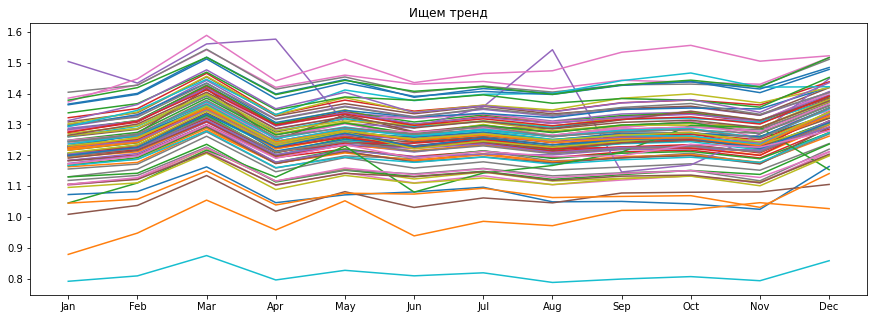

In [280]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data)
plt.title('Ищем тренд')
plt.show()

In [276]:
monthly_data_SD1 = days.pivot_table('val', 'Month', ['territ_subdiv_1'])

monthly_data_SD1 = monthly_data_SD1.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_data_SD1

territ_subdiv_1,1,2,3,4,5,6,7,8,9,10,11
Month,,,,,,,,,,,
Jan,1.240922,1.195952,1.219495,0.792691,1.255324,1.198131,1.231264,1.210156,1.210264,1.184482,1.262786
Feb,1.264577,1.218908,1.244893,0.810136,1.279400,1.218068,1.260289,1.252512,1.231871,1.207402,1.296698
Mar,1.373788,1.322701,1.353229,0.875831,1.386486,1.318250,1.366478,1.362897,1.329006,1.306208,1.399883
Apr,1.256778,1.208284,1.237678,0.796986,1.267959,1.194187,1.242355,1.244326,1.211894,1.194583,1.283165
May,1.294929,1.248256,1.278018,0.828135,1.300884,1.231694,1.288345,1.306060,1.250665,1.232441,1.323639
Jun,1.260920,1.220376,1.246825,0.810317,1.273168,1.202218,1.259874,1.247936,1.234516,1.210862,1.286409
Jul,1.279126,1.239176,1.267293,0.820102,1.295882,1.222770,1.277280,1.276239,1.252056,1.229756,1.307141
Aug,1.256792,1.213416,1.243989,0.788932,1.274598,1.196635,1.257625,1.268293,1.227350,1.202690,1.283461
Sep,1.279002,1.230349,1.265126,0.799929,1.285167,1.217025,1.278370,1.303612,1.245989,1.215966,1.301860


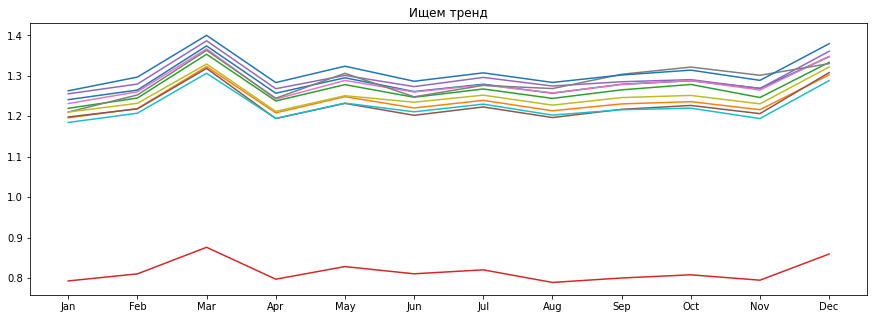

In [289]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data_SD1)
plt.title('Ищем тренд')
plt.show()